### Setup

In [114]:
import pandas as pd
import numpy as np
import altair as alt
from matplotlib.colors import LinearSegmentedColormap
import os
import itertools

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import importlib
import utils
# Cache-Probleme umgehen
importlib.reload(utils)
from utils import format_long_text
from utils import generate_model_names
from utils import load_model
from utils import load_features
from utils import load_results
from utils import full_pipeline
from utils import load_residual_plot
from utils import load_validation_results
from utils import load_summary_table
from utils import run_full_pipeline_with_featurelist
from utils import generate_final_df

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [115]:
# Farbgebung in Diagrammen
color1 = '#06507F'  # Dunkelblau
color2 = '#330241'  # Dunkellila
color3 = '#0076BF'  # Blau
color4 = '#80BADF'  # Hellblau
color5 = '#E7DDFF'  # Helllila
custom_cmap = LinearSegmentedColormap.from_list('custom', ['#FFFFFF', color1])

### Data import

In [116]:
path_data = 'https://raw.githubusercontent.com/mm391-030401/project/refs/heads/main/data/processed/'
file_data= 'data_final.csv'

data = pd.read_csv(path_data + file_data, sep=',', encoding='utf-8')

# Obwohl diese Spalten bereits im Notebook "convert_columns" zu Strings konvertiert wurden, wurden sie beim erneuten Einlesen wieder als Integer erkannt
# Allerdings ist es sinnvoll, diese Spalten nicht als Integer (diskret) zu betrachten 
# sondern als ordinale Variablen (Rechenoperationen sind nicht sinnig für die Zeitangaben)
to_str_cols = ['monat', 'monat_jahr','monat_monat', 'kohorte', 'kohorte_jahr', 'kohorte_monat']

# Konvertierung der Spalten in string 
for col in to_str_cols: 
    data[col] = data[col].astype(str)

### Model Workflow

#### Variables


In [117]:
y_label = 'retentionrate'

In [118]:
# Liste der Strings
strings = [
    'erster_monat_kohorte_fg',
    'monate_seit_einfuehrung_programm_kohorte',
    'monat_monat',
    'kohorte_monat',
    'monat_jahreszeit',
    'kohorte_jahreszeit',
    'rabatt_indexiert'
]

# Generiere alle möglichen Kombinationen (mindestens eine der Strings)
combinations = []
for r in range(1, len(strings) + 1):
    combinations.extend(itertools.combinations(strings, r))

# Umwandeln in eine Liste von Listen
combinations = [list(comb) for comb in combinations]

In [119]:
len(combinations)

127

In [120]:
feature_list = combinations

#### Workflow ohne Transformation

In [121]:
# Modelltyp
modeltype = "Lineare_Regression"

# Beginn der Modellnummerierung
start_num = 1

# Angabe ob Transformierung vorgenommen wurde
is_log_transformed = False

model_names_list = run_full_pipeline_with_featurelist(data, y_label, feature_list, modeltype, start_num, is_log_transformed)


Modell gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\01_20241230-173108_Lineare_Regression.joblib
Features gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\01_20241230-173108_Lineare_Regression_features.json
Ergebnisse gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\01_20241230-173108_Lineare_Regression_results.csv
Kreuzvalidierungsergebnisse gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\01_20241230-173108_Lineare_Regression_validation.csv
Residualplot gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\01_20241230-173108_Lineare_Regression_residual_plot.png
Zusammenfassungstabelle gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\01_20241230-173108_Lineare_Regression_summary.csv
Modell gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistic

##### Review Models

In [122]:
final_df = generate_final_df(model_names_list)
final_df

,Model,R_squared,MSE,RMSE,MAE,Features,validation_count,validation_mean,validation_std,validation_min,validation_25%,validation_50%,validation_75%,validation_max
0,124_20241230-173123_Lineare_Regression,0.704,64.415,8.026,6.100,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'monat_jahreszeit', 'kohorte_jahreszeit', 'rabatt_indexiert']",5.000,59.903,9.047,46.442,55.763,63.241,64.196,69.876
1,106_20241230-173121_Lineare_Regression,0.704,64.415,8.026,6.100,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'monat_jahreszeit', 'rabatt_indexiert']",5.000,59.903,9.047,46.442,55.763,63.241,64.196,69.876
2,121_20241230-173123_Lineare_Regression,0.703,64.632,8.039,6.061,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'monat_monat', 'kohorte_monat', 'monat_jahreszeit', 'rabatt_indexiert']",5.000,60.623,8.250,49.237,54.994,64.614,64.877,69.393
3,101_20241230-173121_Lineare_Regression,0.703,64.632,8.039,6.061,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'monat_monat', 'kohorte_monat', 'rabatt_indexiert']",5.000,60.623,8.250,49.237,54.994,64.614,64.877,69.393
4,127_20241230-173124_Lineare_Regression,0.703,64.632,8.039,6.061,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'monat_monat', 'kohorte_monat', 'monat_jahreszeit', 'kohorte_jahreszeit', 'rabatt_indexiert']",5.000,60.623,8.250,49.237,54.994,64.614,64.877,69.393
5,122_20241230-173123_Lineare_Regression,0.703,64.633,8.039,6.061,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'monat_monat', 'kohorte_monat', 'kohorte_jahreszeit', 'rabatt_indexiert']",5.000,60.623,8.250,49.237,54.994,64.614,64.877,69.393
6,70_20241230-173116_Lineare_Regression,0.703,64.733,8.046,6.164,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'rabatt_indexiert']",5.000,60.365,9.323,45.949,56.984,63.997,64.718,70.176
7,107_20241230-173121_Lineare_Regression,0.703,64.733,8.046,6.164,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'kohorte_jahreszeit', 'rabatt_indexiert']",5.000,60.365,9.323,45.949,56.984,63.997,64.718,70.176
8,105_20241230-173121_Lineare_Regression,0.702,65.031,8.064,6.384,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'monat_jahreszeit', 'kohorte_jahreszeit']",5.000,62.401,8.482,50.090,60.385,61.634,66.976,72.920
9,68_20241230-173116_Lineare_Regression,0.702,65.031,8.064,6.384,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'monat_jahreszeit']",5.000,62.401,8.482,50.090,60.385,61.634,66.976,72.920


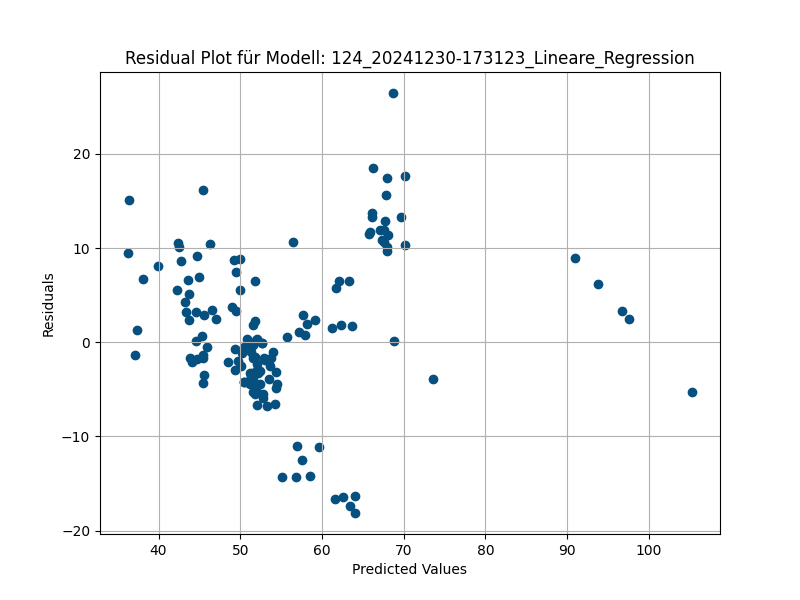

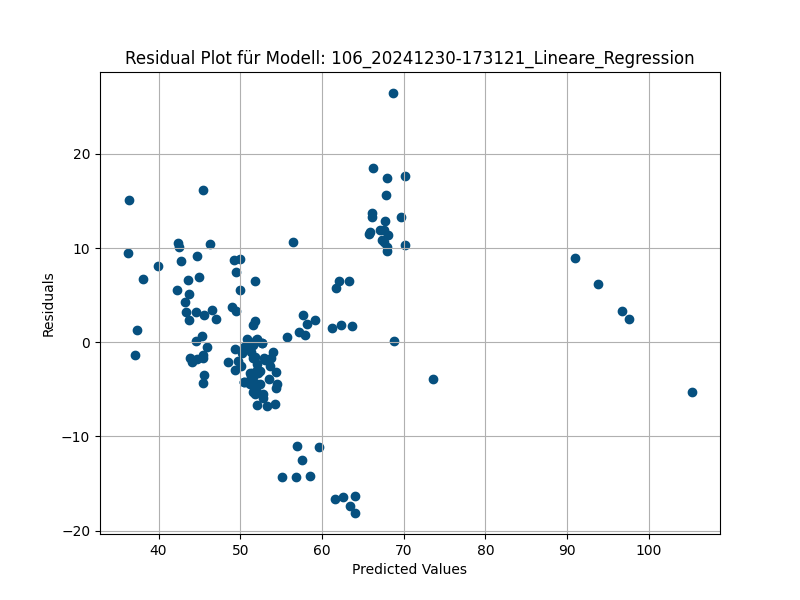

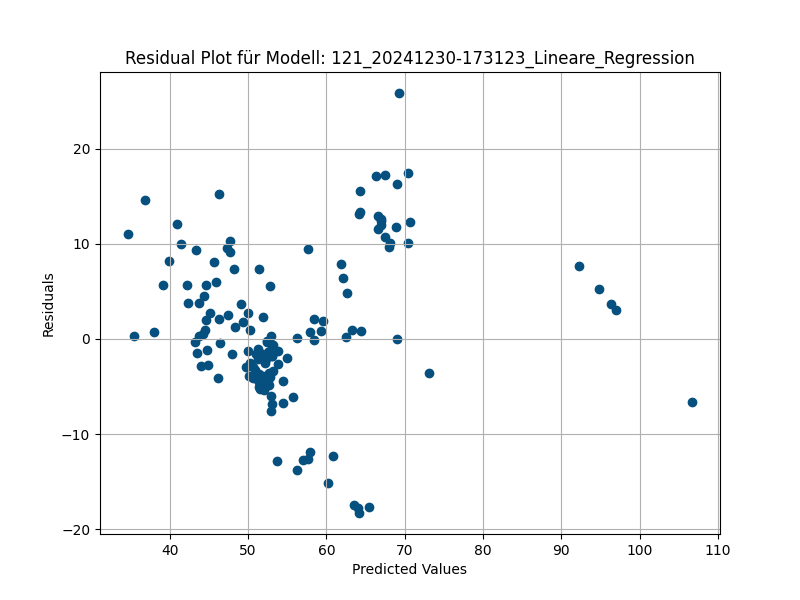

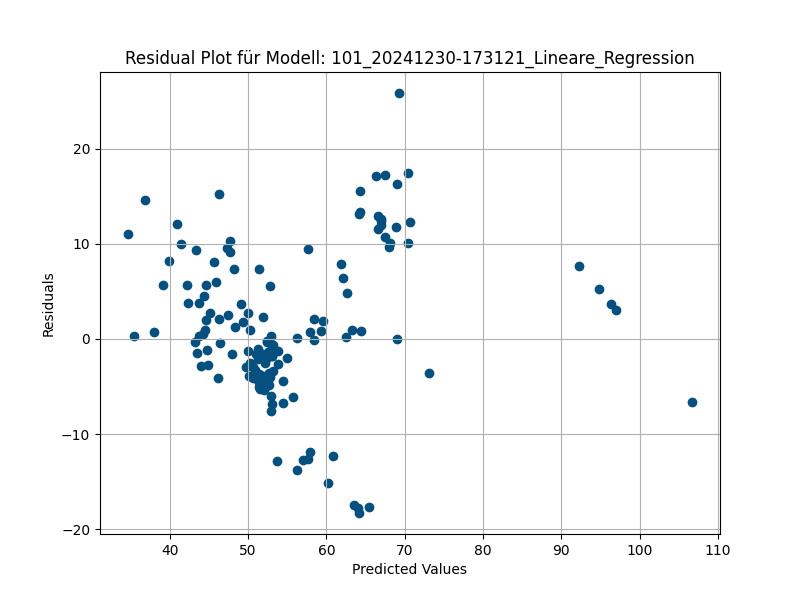

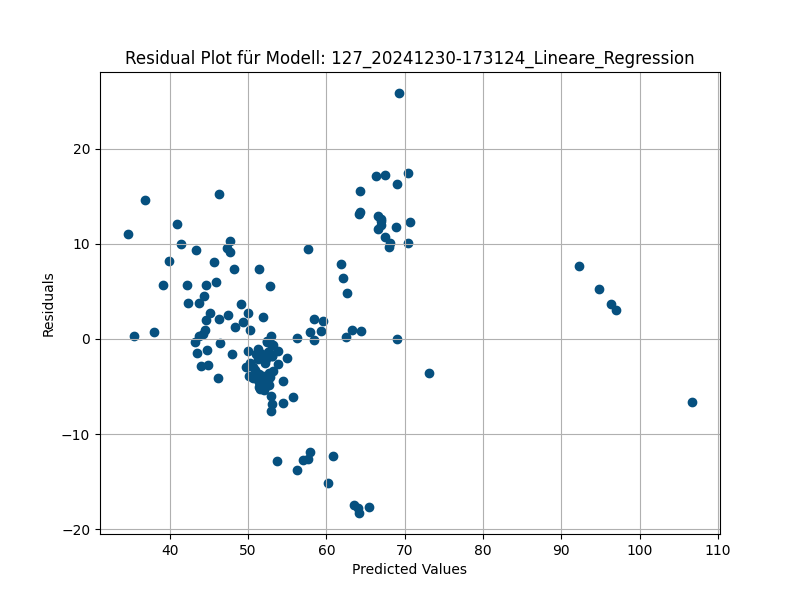

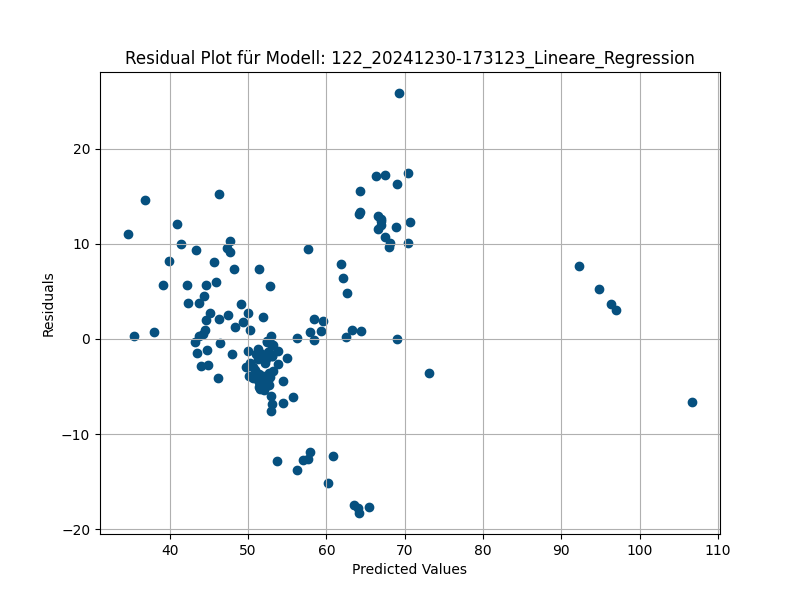

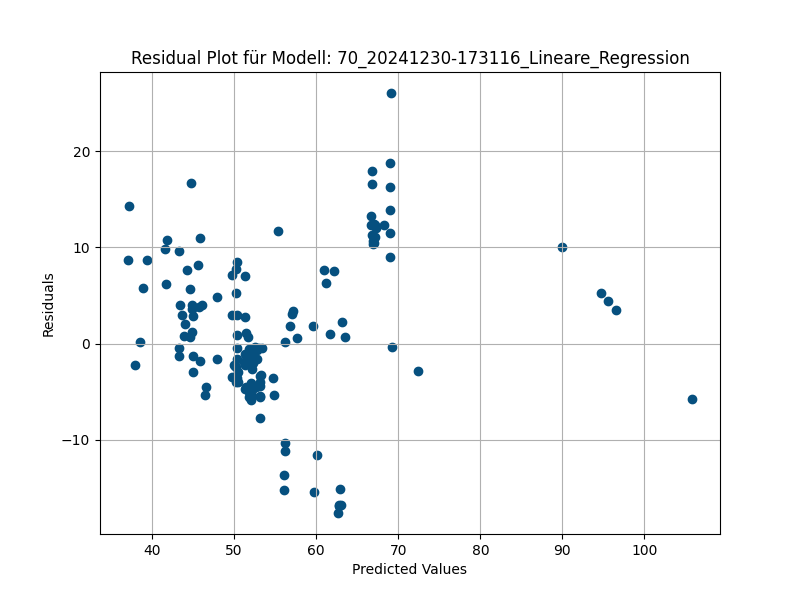

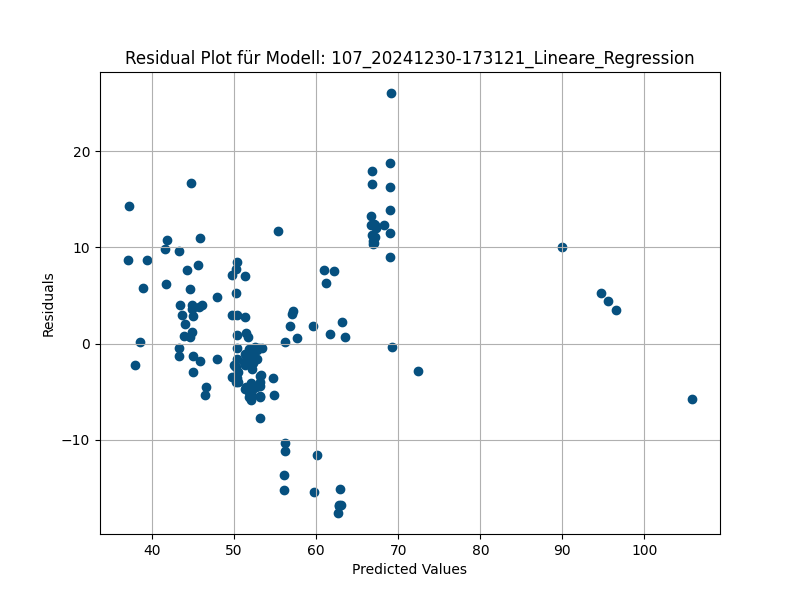

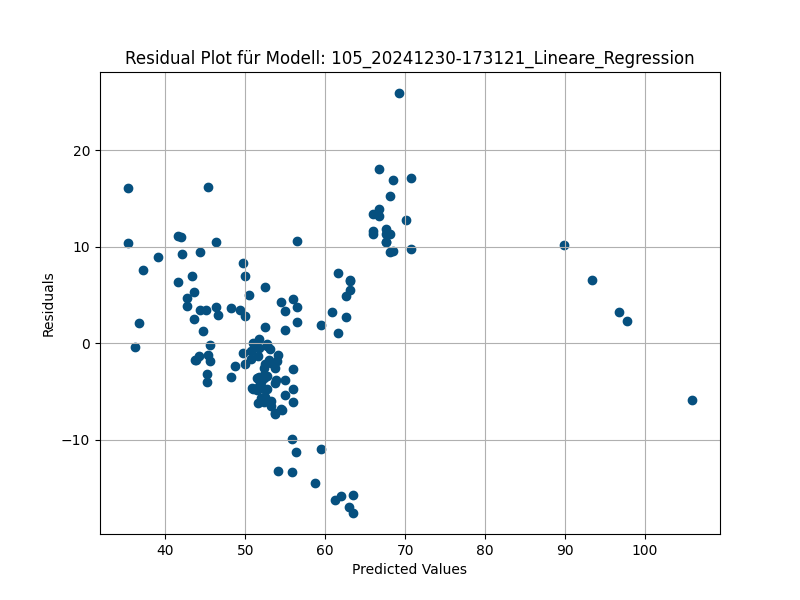

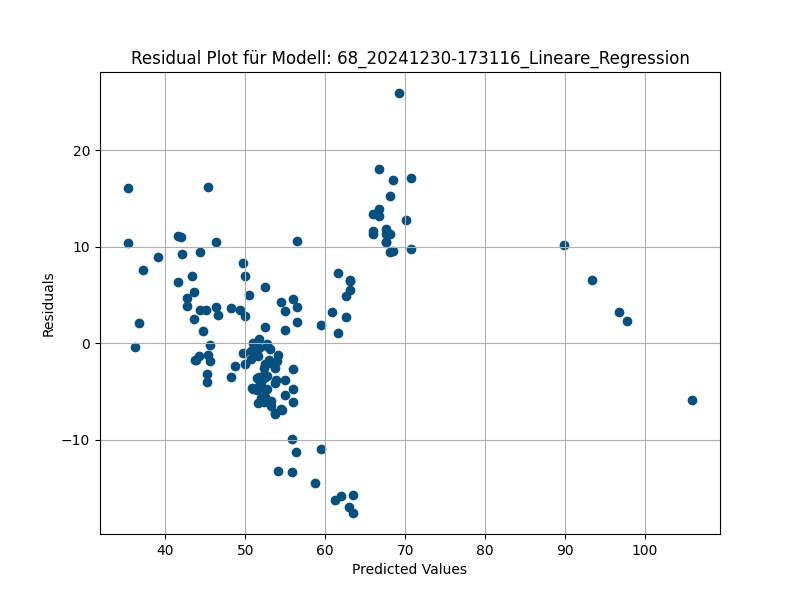

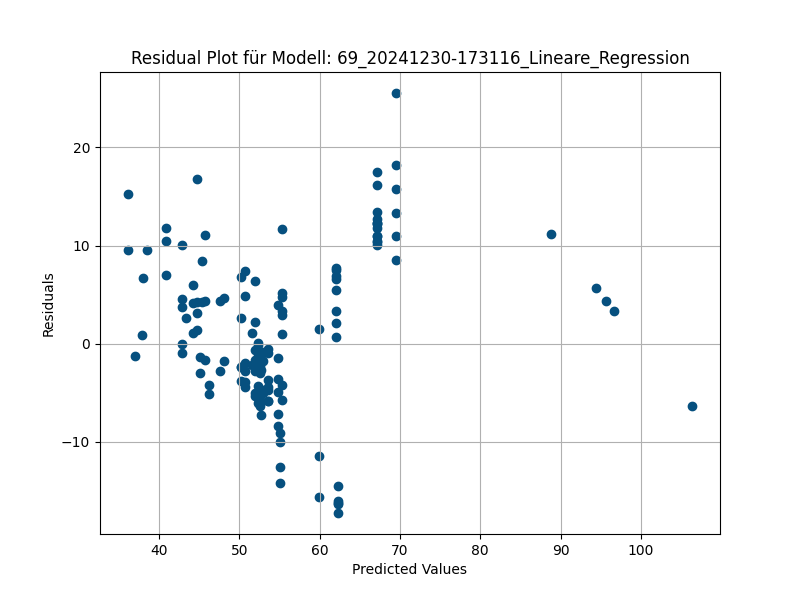

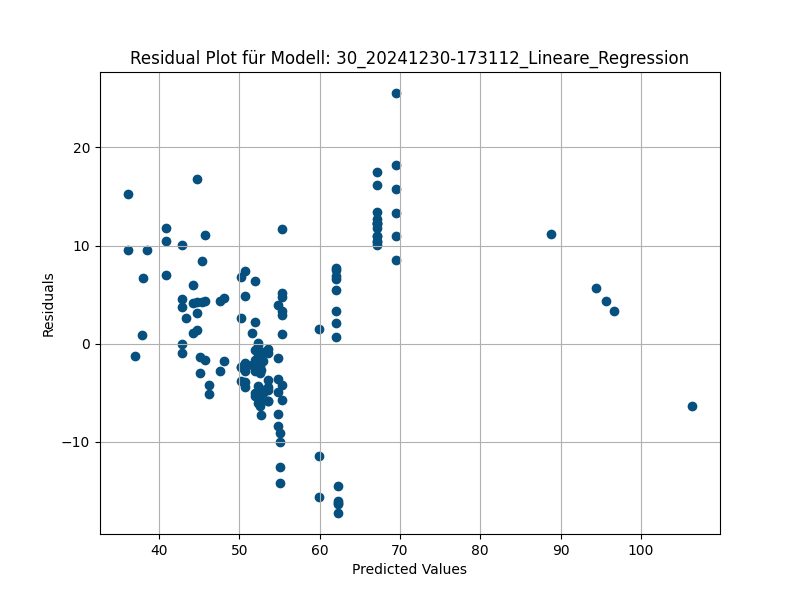

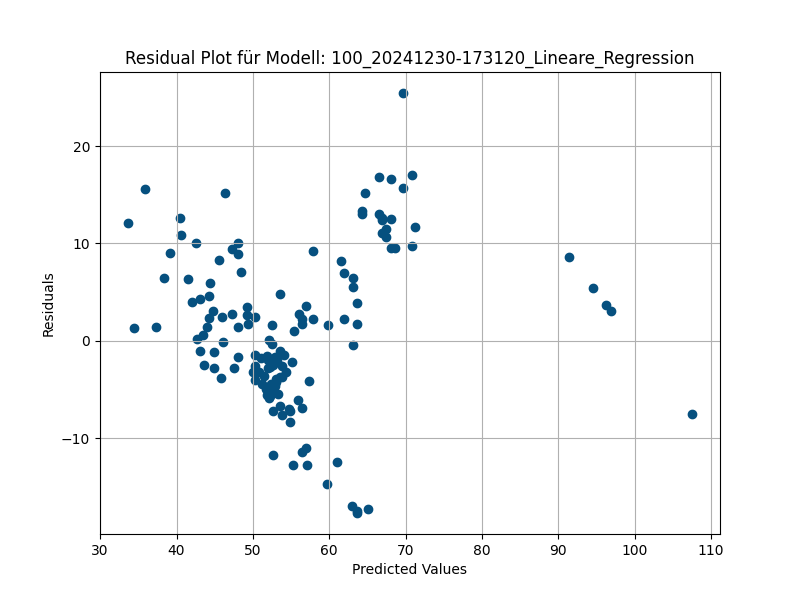

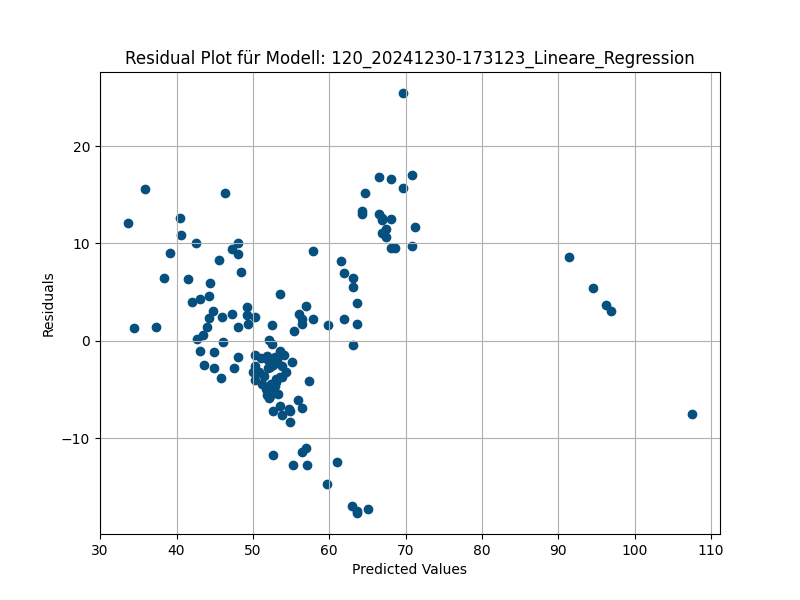

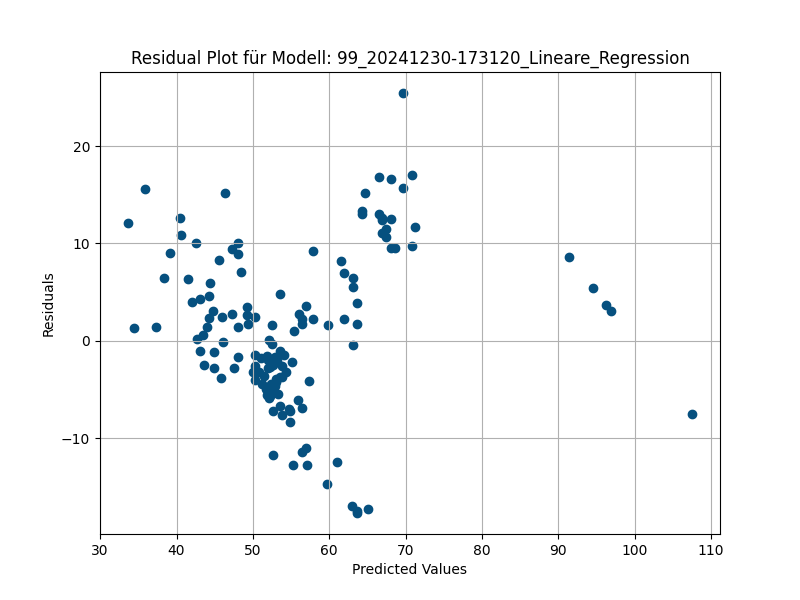

In [123]:
for name in final_df.data['Model']:
    load_residual_plot(name)

#### Workflow mit logarithmischer Transformation

In [124]:
data_transformed = data.copy()
data_transformed[['retentionrate', 'rabatt_indexiert']] = data_transformed[['retentionrate', 'rabatt_indexiert']].apply(np.log)

In [125]:
# Modelltyp
modeltype = "Lineare_Regression_log_transform"

# Beginn der Modellnummerierung
start_num = 128

# Angabe ob Transformierung vorgenommen wurde
is_log_transformed = True

model_names_list_transformed = run_full_pipeline_with_featurelist(data_transformed, y_label, feature_list, modeltype, start_num, is_log_transformed)

Modell gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\128_20241230-173130_Lineare_Regression_log_transform.joblib
Features gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\128_20241230-173130_Lineare_Regression_log_transform_features.json
Ergebnisse gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\128_20241230-173130_Lineare_Regression_log_transform_results.csv
Kreuzvalidierungsergebnisse gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\128_20241230-173130_Lineare_Regression_log_transform_validation.csv
Residualplot gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\128_20241230-173130_Lineare_Regression_log_transform_residual_plot.png
Zusammenfassungstabelle gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\128_20241230-173130_Lineare_Regression_log_transf

In [126]:
final_df_transformed = generate_final_df(model_names_list_transformed)
final_df_transformed

,Model,R_squared,MSE,RMSE,MAE,Features,validation_count,validation_mean,validation_std,validation_min,validation_25%,validation_50%,validation_75%,validation_max
0,232_20241230-173143_Lineare_Regression_log_transform,0.698,65.813,8.113,6.303,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'monat_jahreszeit', 'kohorte_jahreszeit']",5.000,0.017,0.002,0.015,0.016,0.017,0.018,0.020
1,195_20241230-173138_Lineare_Regression_log_transform,0.698,65.813,8.113,6.303,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'monat_jahreszeit']",5.000,0.017,0.002,0.015,0.016,0.017,0.018,0.020
2,227_20241230-173142_Lineare_Regression_log_transform,0.697,66.004,8.124,6.234,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'monat_monat', 'kohorte_monat', 'kohorte_jahreszeit']",5.000,0.017,0.002,0.015,0.016,0.017,0.017,0.020
3,247_20241230-173145_Lineare_Regression_log_transform,0.697,66.004,8.124,6.234,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'monat_monat', 'kohorte_monat', 'monat_jahreszeit', 'kohorte_jahreszeit']",5.000,0.017,0.002,0.015,0.016,0.017,0.017,0.020
4,191_20241230-173138_Lineare_Regression_log_transform,0.697,66.004,8.124,6.234,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'monat_monat', 'kohorte_monat']",5.000,0.017,0.002,0.015,0.016,0.017,0.017,0.020
5,226_20241230-173142_Lineare_Regression_log_transform,0.697,66.004,8.124,6.234,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'monat_monat', 'kohorte_monat', 'monat_jahreszeit']",5.000,0.017,0.002,0.015,0.016,0.017,0.017,0.020
6,233_20241230-173143_Lineare_Regression_log_transform,0.695,66.393,8.148,6.221,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'monat_jahreszeit', 'rabatt_indexiert']",5.000,0.017,0.002,0.015,0.016,0.018,0.018,0.020
7,251_20241230-173145_Lineare_Regression_log_transform,0.695,66.393,8.148,6.221,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'kohorte_monat', 'monat_jahreszeit', 'kohorte_jahreszeit', 'rabatt_indexiert']",5.000,0.017,0.002,0.015,0.016,0.018,0.018,0.020
8,254_20241230-173146_Lineare_Regression_log_transform,0.695,66.409,8.149,6.183,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'monat_monat', 'kohorte_monat', 'monat_jahreszeit', 'kohorte_jahreszeit', 'rabatt_indexiert']",5.000,0.017,0.002,0.015,0.016,0.017,0.018,0.020
9,228_20241230-173142_Lineare_Regression_log_transform,0.695,66.410,8.149,6.183,"['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte', 'monat_monat', 'kohorte_monat', 'rabatt_indexiert']",5.000,0.017,0.002,0.015,0.016,0.017,0.018,0.020


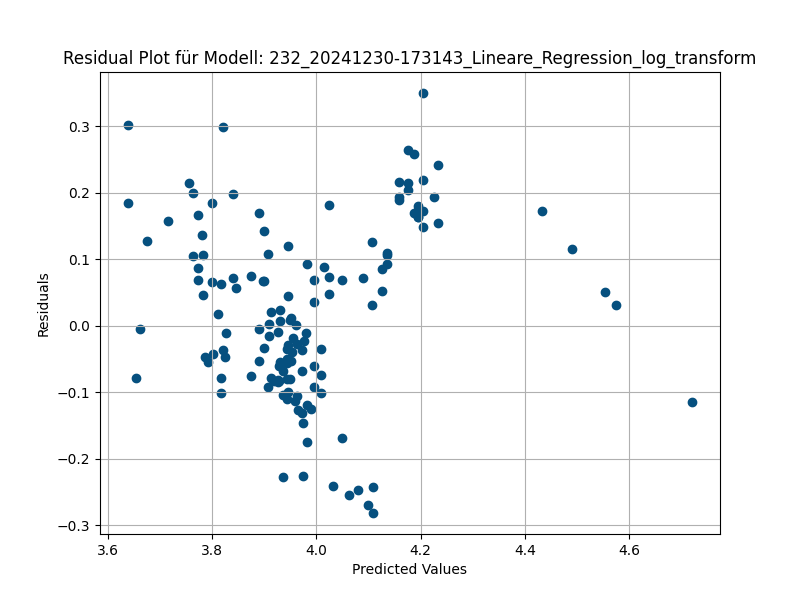

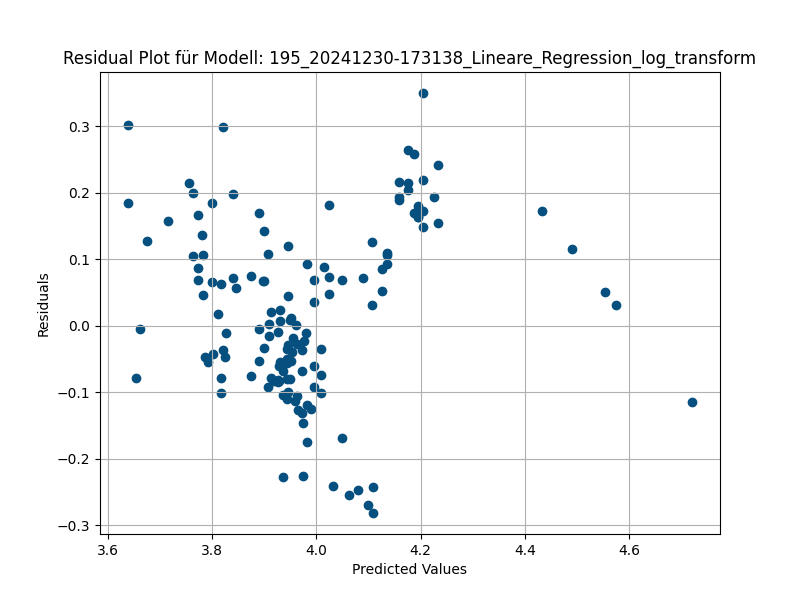

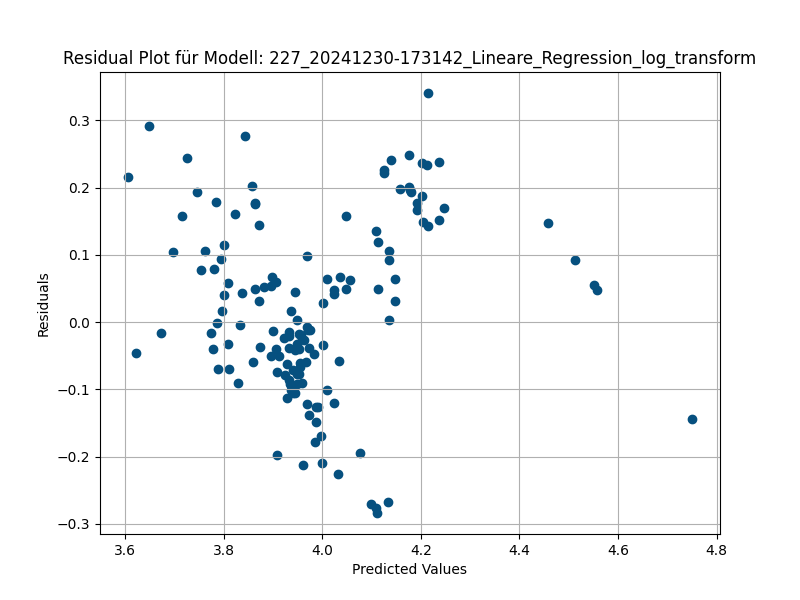

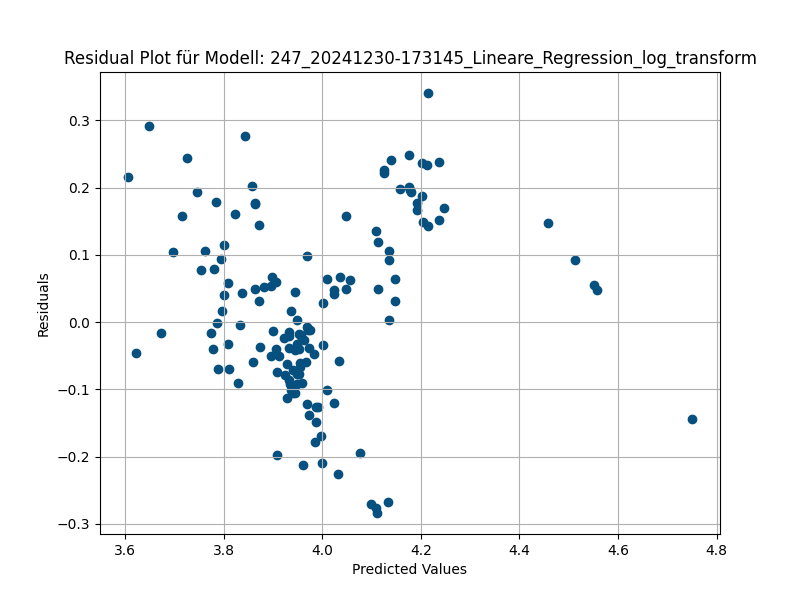

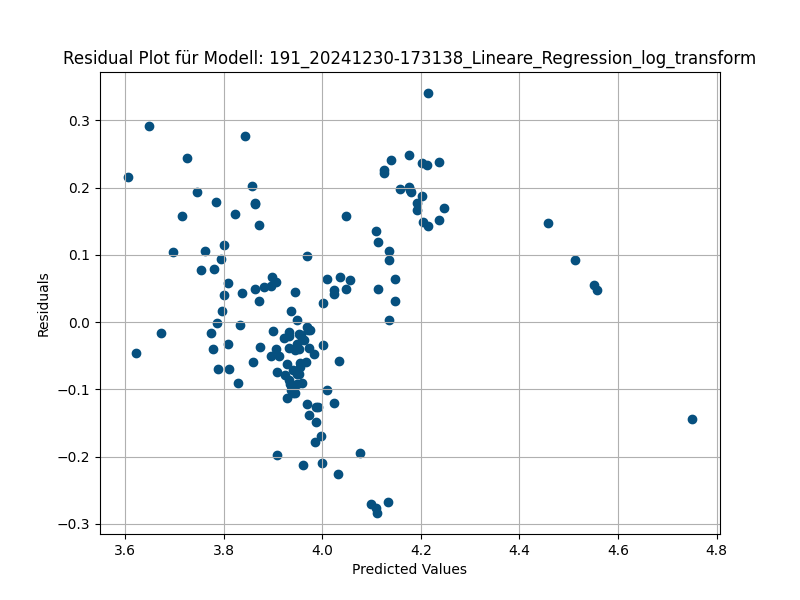

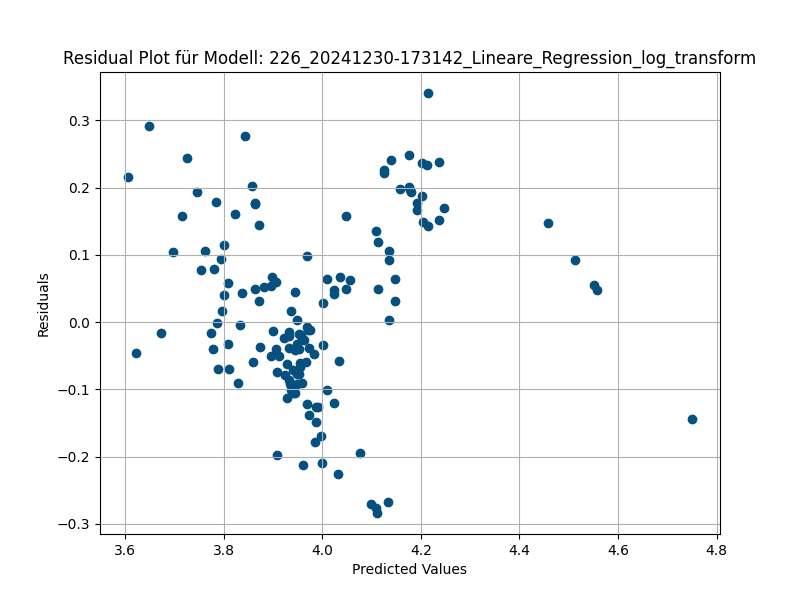

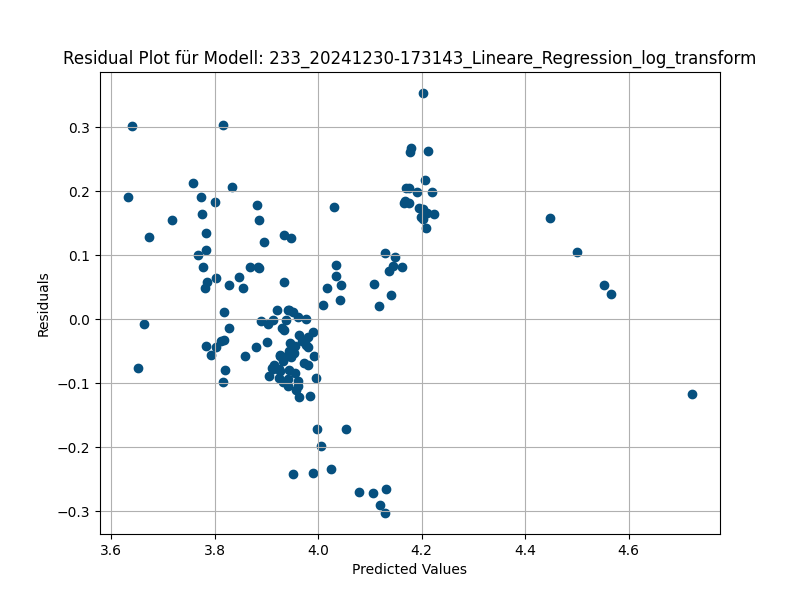

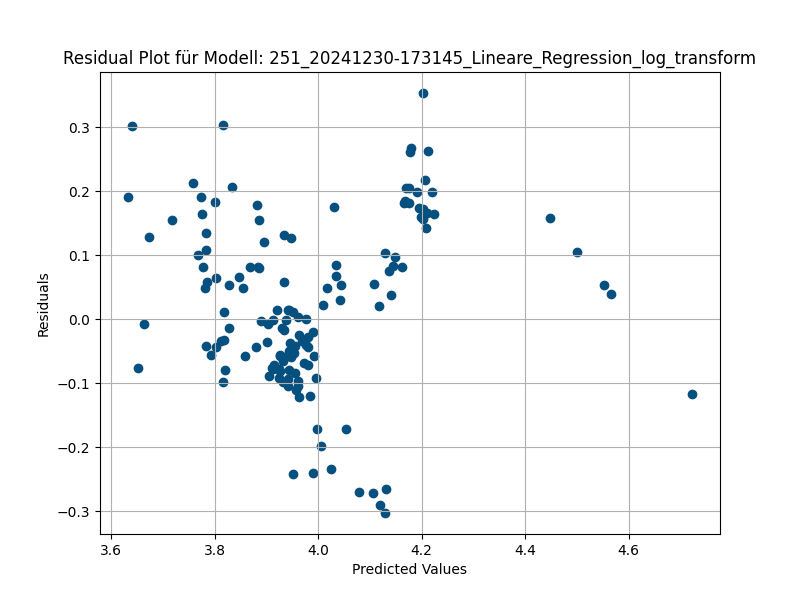

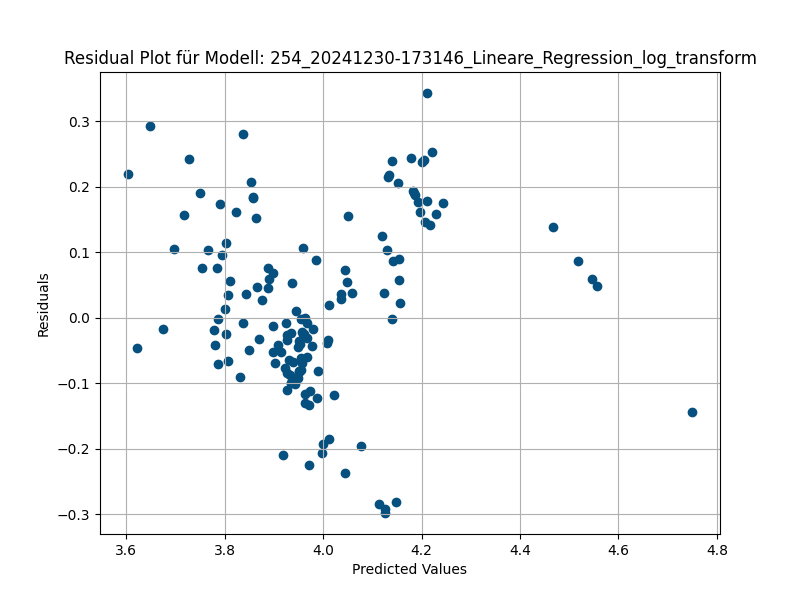

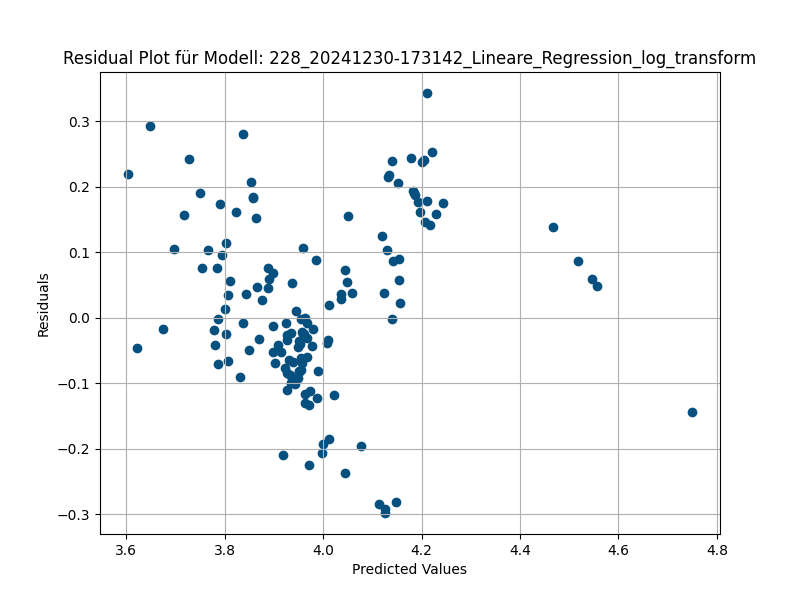

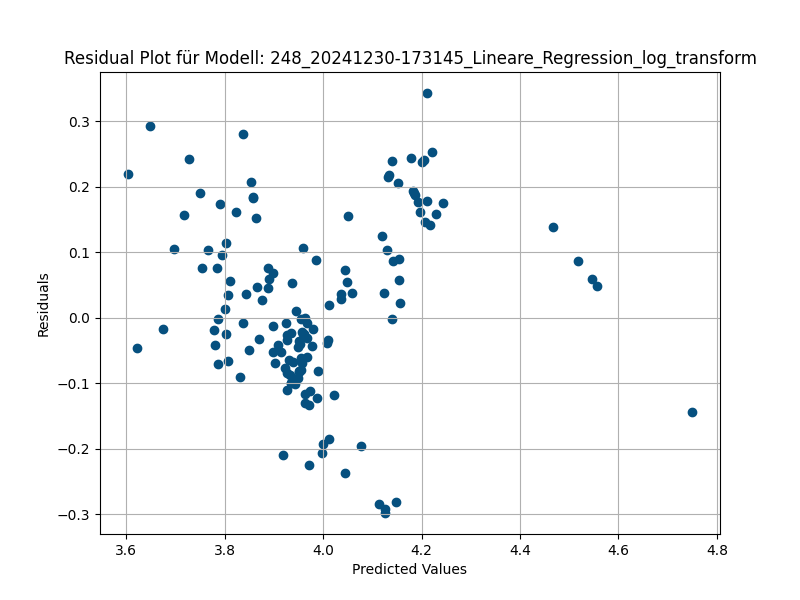

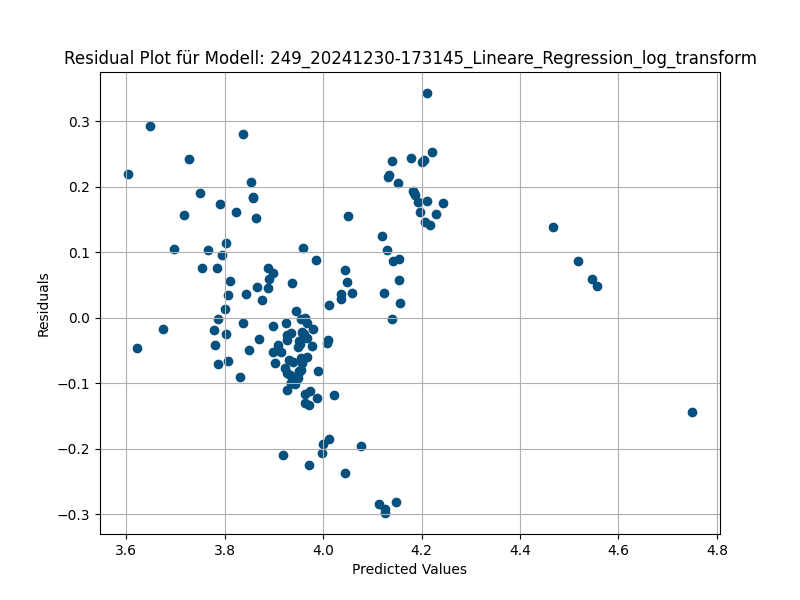

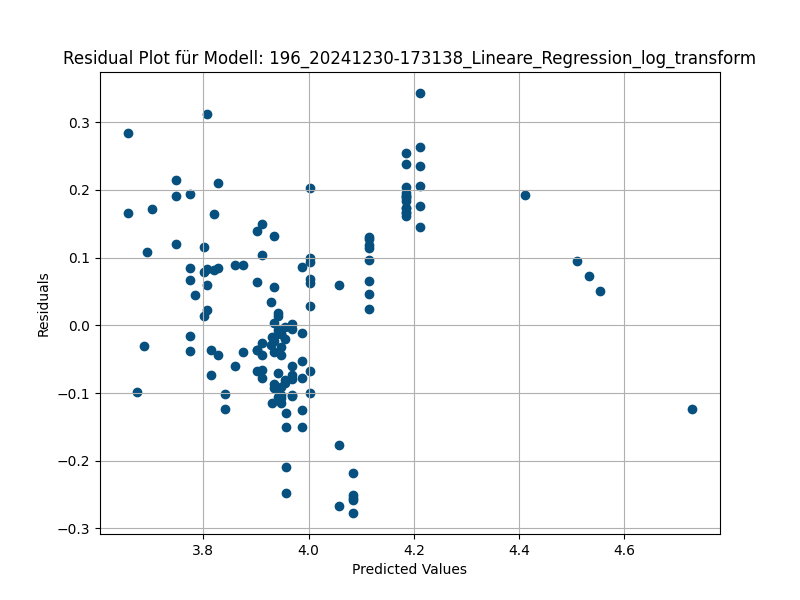

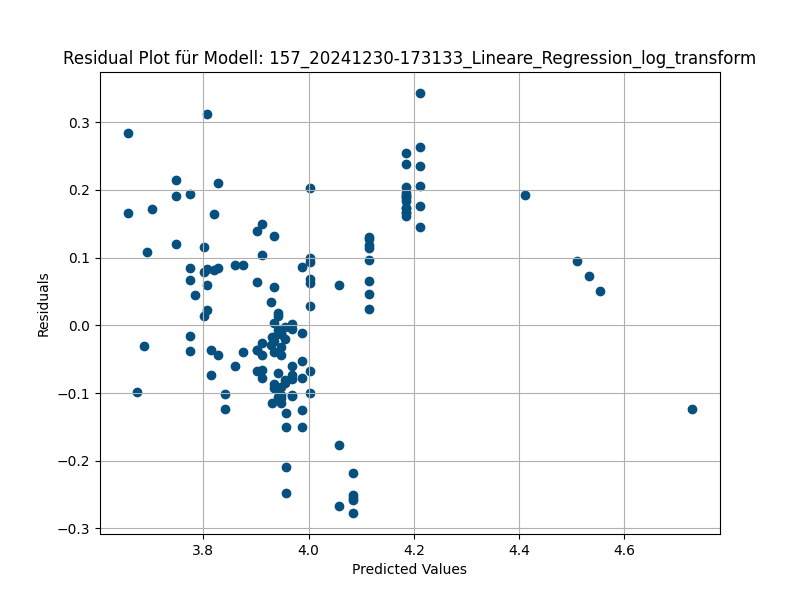

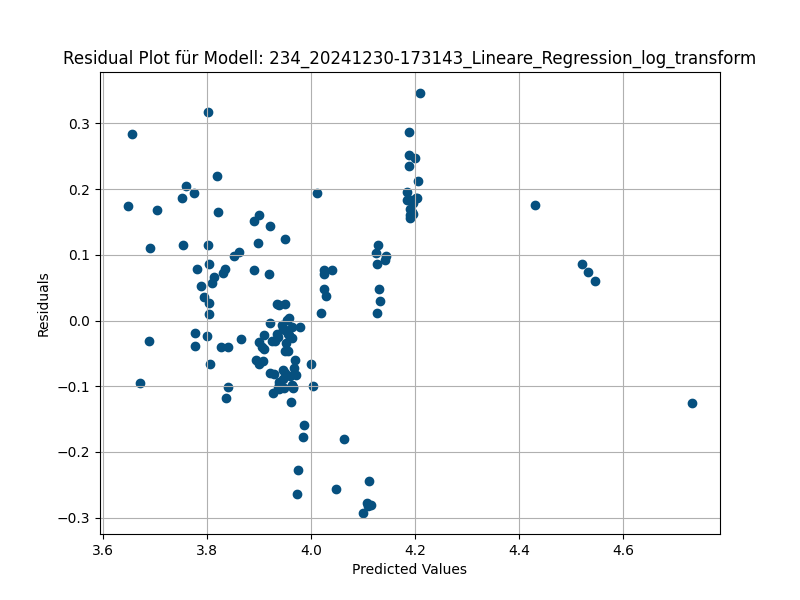

In [127]:
for name in final_df_transformed.data['Model']:
    load_residual_plot(name)

### Model 1. Try

#### Variables

In [103]:
y_label = 'retentionrate'
features = ['erster_monat_kohorte_fg', 'monate_seit_einfuehrung_programm_kohorte']

In [104]:
# Name des aktuell getesteten Modells
model_name = '02_20241229_Lineare_Regression_Basic'

#### Pipeline

In [105]:
full_pipeline(data, y_label, features, model_name)

Modell gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\02_20241229_Lineare_Regression_Basic.joblib
Features gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\02_20241229_Lineare_Regression_Basic_features.json
Ergebnisse gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\02_20241229_Lineare_Regression_Basic_results.csv
Kreuzvalidierungsergebnisse gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\02_20241229_Lineare_Regression_Basic_validation.csv
Residualplot gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\02_20241229_Lineare_Regression_Basic_residual_plot.png
Zusammenfassungstabelle gespeichert unter: c:\Users\miche\HdM\Data Analytics with Statistics\Git\project\models\02_20241229_Lineare_Regression_Basic_summary.csv

Modellzusammenfassung:
                                       Name  Coefficient

#### Model

In [106]:
load_model(model_name)

LinearRegression()

#### Training and Validation

In [107]:
df_scores = pd.DataFrame(load_validation_results(model_name))
df_scores

,MSE
0,99.282139
1,73.893149
2,87.929751
3,73.005082
4,99.436467


In [108]:
df_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
MSE,5.0,86.709317,12.976959,73.005082,73.893149,87.929751,99.282139,99.436467


#### Fit Model

In [109]:
load_summary_table(model_name)

,Name,Coefficient
0,Intercept,59.542
1,erster_monat_kohorte_fg,52.030
2,monate_seit_einfuehrung_programm_kohorte,-0.720


#### Evaluation on test set

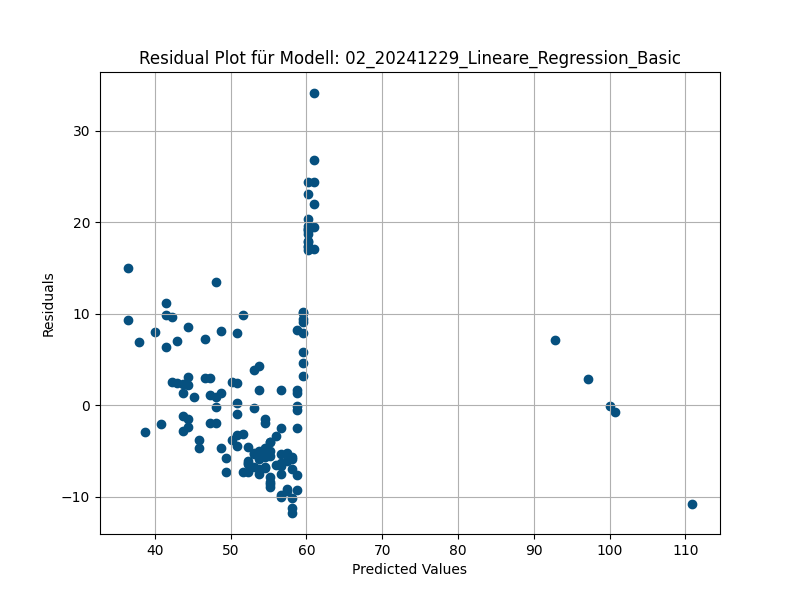

In [110]:
load_residual_plot(model_name)

In [111]:
pd.DataFrame(load_results(model_name))

,R_squared,MSE,RMSE,MAE
0,0.564548,94.883149,9.740798,7.466831
